In [56]:
from phidl import Device, Layer, LayerSet, Port
from phidl.device_layout import DeviceReference
from phidl import quickplot as qp
from phidl import set_quickplot_options

import phidl.geometry as pg
import phidl.utilities as pu
import phidl.routing as pr
import phidl.path as pp

import numpy as np
import pickle

from dataclasses import dataclass, field, replace

from typing import Tuple, Optional, Union

import itertools
import importlib

from components import utils
importlib.reload(utils)

from components import default_layerset
importlib.reload(default_layerset)
from components import frame
importlib.reload(frame)
from components import feedline
importlib.reload(feedline)
from components import spiral
importlib.reload(spiral)
from components import junction
importlib.reload(junction)
from components import resistor
importlib.reload(resistor)
from components import junction_resistor
importlib.reload(junction_resistor)
from components import ground_capacitor
importlib.reload(ground_capacitor)
from components import squid_resistor
importlib.reload(squid_resistor)
from components import junction_squid_resistor
importlib.reload(junction_squid_resistor)
from components import squid
importlib.reload(squid)

from components.default_layerset import default_ls
from components.frame import Frame, FrameParams
from components.feedline import Feedline, FeedlineParams, SquarePortParams
from components.spiral import Spiral, SpiralParams
from components.junction import JJ, JJParams
from components.resistor import Resistor, ResParams
from components.junction_resistor import JJResistor, CapaParams
from components.ground_capacitor import GroundCapa, GroundCapaParams
from components.squid_resistor import SquidResistor, SquidParams
from components.junction_squid_resistor import JJSquidResistor
from components.squid import Squid
from components.utils import WritefieldParams

# set_quickplot_options(show_subports=False, show_ports=False)

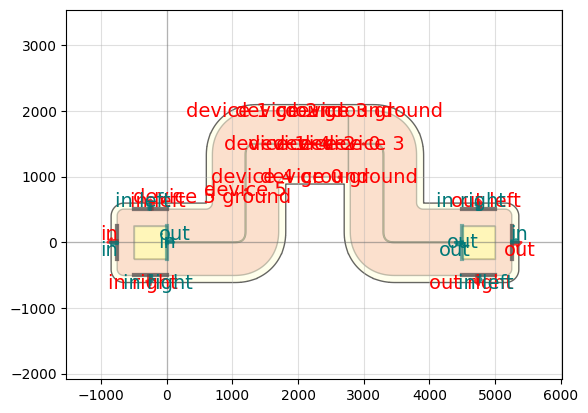

In [57]:
feedline_right = Feedline()

feedline_points = [(0, 0), (1200, 0), (1200, 1500), (3300, 1500), (3300, 0), (4500, 0)]
# device_points = [(1200, 600), (1200, 1000), (1200, 1400), (3300, 1400), (3300, 1000), (3300, 600)]
# ground_points = [(700, 600), (700, 1000), (700, 1400), (3800, 1400), (3800, 1000), (3800, 600)]

# device_points = [(1200, 500), (1200, 1300), (2250, 1500), (3300, 1300), (3300, 500)]
# device_orientations = [0, 180, 90, 0, 180]
# ground_points = [(1705, 500), (695, 1300), (2250, 2005), (3805, 1300), (2795, 500)]

device_points = [(2625, 1500), (1500, 1500), (2250, 1500), (3000, 1500), (1875, 1500)] + [(1200, 800)]
device_orientations = [-90, 90, 90, 90, -90] + [180]
ground_points = [(2625, 995), (1500, 2005), (2250, 2005), (3000, 2005), (1875, 995)] + [695, 800]

feedline_right.generate_feedline(FeedlineParams(feedline_points=feedline_points, 
                                               device_points=device_points, 
                                               device_ground_points=ground_points,
                                               device_orientations=device_orientations))




qp(feedline_right.device)

In [58]:
# make spirals
Ns = [15.5, 15.6, 15.3, 15.2]
print(Ns)

spirals: list[Spiral] = []

for N in Ns:
    spiral = Spiral()
    spiral.generate_spiral(SpiralParams(N=N, connector_length=0))

    spirals.append(spiral)

spiral = Spiral()
spiral.generate_spiral(SpiralParams(N=15.9, connector_length=0))
spirals.insert(2, spiral)

print([np.round(spiral.get_resonance_frequency()) for spiral in spirals])

[15.5, 15.6, 15.3, 15.2]
[8657103740.0, 8537503993.0, 8191480325.0, 8903009562.0, 9029427639.0]


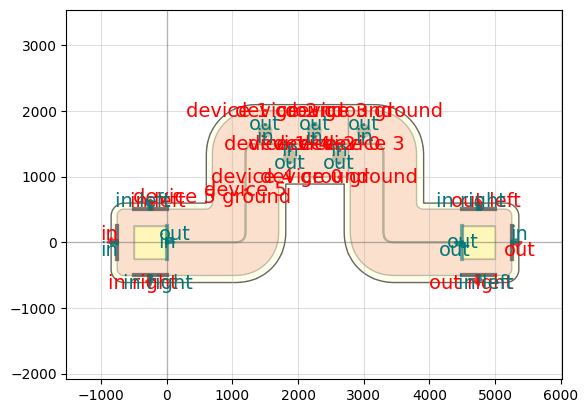

In [59]:
coupling_distance = 100
Resonators: list[DeviceReference] = []

for i,spiral in enumerate(spirals):
    Resonators.append(feedline_right.device << spiral.device)

    Resonators[-1].connect('in', feedline_right.device.ports[f'device {i}'])

    #angle = device_orientations[i]*((2*np.pi)/360)
    #Resonators[-1].move((coupling_distance * np.cos(angle), coupling_distance * np.sin(angle)))
    normal = Resonators[-1].ports['out'].normal[1] - Resonators[-1].ports['out'].normal[0]
    Resonators[-1].move(normal * coupling_distance)

#feedline_bot.correct_optical_layer()

qp(feedline_right.device)

In [60]:
capa_spacing = 2
shadow_shift = 0.3

def connect_to_resonator(element: Union[JJResistor, SquidResistor, JJSquidResistor, Squid, JJ],
                         element_port_name: str,
                         resonator: DeviceReference, 
                         capa_distance: float = capa_spacing + shadow_shift) -> None:

    element_port = element.device.ports[element_port_name]

    resonator_normal = resonator.ports['out'].normal[1] - resonator.ports['out'].normal[0]
    element_normal = element_port.normal[1] - element_port.normal[0]

    angle = np.round((360/(2*np.pi)) * np.arccos(np.clip(np.dot(resonator_normal,-element_normal), -1, 1)))%360

    if angle != 0:
        element.device.rotate(-angle)
        element.device.mirror()

    element.device.move(element_port, resonator.ports['out'])
    element.device.move(capa_distance * resonator_normal)

def add_ground_capacitor(element: Union[JJResistor, SquidResistor, JJSquidResistor],
                         element_port_name: str, 
                         feedline: Feedline,
                         device_number: int, 
                         capa_distance: float = capa_spacing + shadow_shift) -> None:

    element_port: Port = element.device.ports[element_port_name]

    distance_to_ground = np.abs(- element_port.y + feedline.device.ports[f'device {device_number} ground'].y) + np.abs(- element_port.x + feedline.device.ports[f'device {device_number} ground'].x) + capa_distance

    ground_capa = GroundCapa()
    ground_capa.generate_ground_capa(GroundCapaParams(distance_to_ground=distance_to_ground, orientation=-90))

    ground_capa_ref = feedline.device << ground_capa.device

    ground_normal = feedline.device.ports[f'device {device_number} ground'].normal[1] - feedline.device.ports[f'device {device_number} ground'].normal[0]
    capa_normal = ground_capa.pad.ports['ground'].normal[1] - ground_capa.pad.ports['ground'].normal[0]
    
    angle = np.round((360/(2*np.pi)) * np.arccos(np.clip(np.dot(ground_normal, capa_normal), -1, 1)))%360

    if angle != 0:
        ground_capa.device.rotate(angle)

    ground_capa.device.move(ground_capa.plate.ports['capa'], element_port)
    ground_capa.device.move(-capa_distance * ground_normal)

    feedline.device << ground_capa.device

In [61]:

QuantumCircuits: list[DeviceReference] = []

writefield_params = WritefieldParams()

### standard junction alone
junction = JJResistor()
junction.generate_junction_resistor(ResParams(total_spacing=20, num_segments=2, segment_length=10, adaptive_spacing=True),
                                       JJParams(),
                                       CapaParams(length_y=0+1.9),
                                       writefield_params)

junction.device.mirror()


connect_to_resonator(junction, 'capa top', Resonators[0])

junction.device.remove(junction.resistor_ref)

#connect_to_resonator(squid, Resonators[0], 0)

QuantumCircuits.append(feedline_right.device << junction.device)

add_ground_capacitor(junction, 'capa bot', feedline_right, device_number=0)

squid_params = SquidParams()
capa_params = CapaParams(length_y=12+1.9)

res_params = ResParams(small_resistor=True, connectors=False, num_segments=5, segment_length=25) #10kOhm

squid_resistor = SquidResistor()
squid_resistor.generate_squid_resistor(res_params, squid_params, capa_params, writefield_params)
squid_resistor.device.mirror()

connect_to_resonator(squid_resistor, 'capa top', Resonators[1])
#connect_to_resonator(squid, Resonators[1], 1)

QuantumCircuits.append(feedline_right.device << squid_resistor.device)

add_ground_capacitor(squid_resistor, 'capa bot', feedline_right, device_number=1)



### small junction alone
junction = JJResistor()
junction.generate_junction_resistor(ResParams(total_spacing=20, num_segments=2, segment_length=10, adaptive_spacing=True),
                                       JJParams(jj_width=0.12, bridge_width=0.4),
                                       CapaParams(length_y=0+1.9, ebeam_capa_width=10),
                                       writefield_params)

junction.device.mirror()



connect_to_resonator(junction, 'capa bot', Resonators[3])

junction.device.remove(junction.resistor_ref)

QuantumCircuits.append(feedline_right.device << junction.device)

add_ground_capacitor(junction, 'capa top', feedline_right, device_number=3)

squid_params = SquidParams(bridge_width = 0.4, jj_width=0.12)
capa_params.ebeam_capa_width = 10


squid_resistor = SquidResistor()
squid_resistor.generate_squid_resistor(res_params, squid_params, capa_params, writefield_params)
squid_resistor.device.mirror()

connect_to_resonator(squid_resistor, 'capa bot', Resonators[4])

QuantumCircuits.append(feedline_right.device << squid_resistor.device)

add_ground_capacitor(squid_resistor, 'capa top', feedline_right, device_number=4)





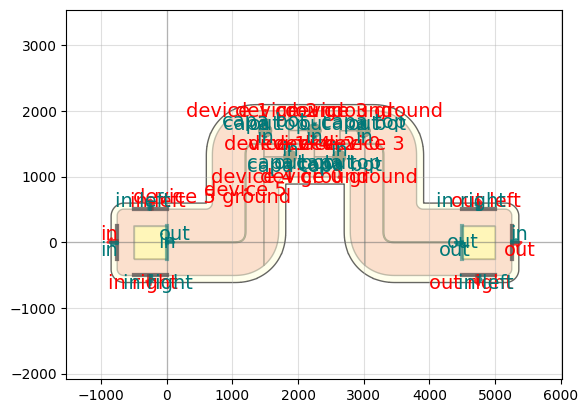

In [62]:
#feedline_right.device.rotate(90)

feedline_right.correct_optical_layer()

qp(feedline_right.device)


In [63]:
# Extra spiral


spiral = Spiral()
spiral.generate_spiral(SpiralParams(N=35, connector_length=0))

print(spiral.get_resonance_frequency())

Resonators.append(feedline_right.device << spiral.device)

i = len(device_points) -1
Resonators[-1].connect('in', feedline_right.device.ports[f'device {i}'])

#angle = device_orientations[i]*((2*np.pi)/360)
#Resonators[-1].move((coupling_distance * np.cos(angle), coupling_distance * np.sin(angle)))
normal = Resonators[-1].ports['out'].normal[1] - Resonators[-1].ports['out'].normal[0]
Resonators[-1].move(normal * coupling_distance*1/2)


# Add squid to extra spiral

squid = Squid()
squid.generate_squid(SquidParams(connectors=False, loop_height=18))
utils.add_writefield(writefield_params, squid.device)

squid.device.mirror()


connect_to_resonator(squid, 'top', Resonators[-1])

squid.device.rotate(90, center=squid.device.center)

squid.device.move((200, 226))

feedline_right.device << squid.device

Ground_Capa = pg.rectangle(size=(300, 3), layer=default_ls['routing'])
Ground_Capa.move(origin=(Ground_Capa.xmax, Ground_Capa.ymin), destination=(squid.device.xmax, squid.device.ymax))
Ground_Capa.move((-39,-35))


feedline_right.device << Ground_Capa


feedline_right.correct_optical_layer()

847974566.0857849


In [64]:
feedline_right.device.write_gds('Feedline_Right.gds')

with open('feedline_right.pkl', 'wb') as f:
    pickle.dump(feedline_right, f)

In [65]:
feedline_right.device.mirror(p1=(-1,0), p2=(1,0))


# feedline_right.device.write_gds('Feedline_Left.gds')

# with open('feedline_left.pkl', 'wb') as f:
#     pickle.dump(feedline_right, f)

Device (name "Feed line" (uid 2616), ports ['in', 'out', 'in left', 'in right', 'out right', 'out left', 'device 0', 'device 1', 'device 2', 'device 3', 'device 4', 'device 5', 'device 0 ground', 'device 1 ground', 'device 2 ground', 'device 3 ground', 'device 4 ground', 'device 5 ground'], aliases [], 0 polygons, 27 references)

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

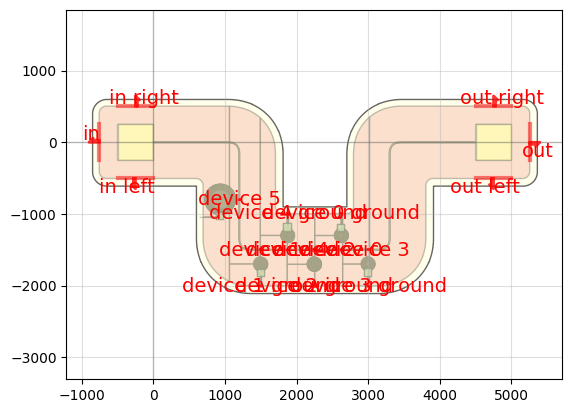

In [66]:
qp(feedline_right.device)